# RQ1 Emissions Reporting Analysis

This script contains the analysis for the RQ1 Emissions Reporting Analysis for the 'What is the Carbon Footprint of ML Models on
Hugging Face? A Repository Mining Study' paper. The analysis can be replicated by executing the cells in order, please make sure the dataset referenced in read_df_processed is in the corresponding directory.

In [25]:
import time
import pandas as pd
import numpy as np
import re
import Levenshtein
import ast
import matplotlib.pyplot as plt
import yaml

from huggingface_hub import HfApi
from huggingface_hub import ModelSearchArguments, DatasetSearchArguments, ModelCard
from huggingface_hub import hf_hub_url, get_hf_file_metadata
from difflib import SequenceMatcher

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib

pd.options.mode.chained_assignment = None

In [62]:
def read_df_processed():
    df = pd.read_csv('../../datasets/HFTotalProcessed.csv')
    df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
    df['library_name'] = df['library_name'].apply(lambda libraries:  ast.literal_eval(libraries) if not isinstance(libraries, list) else libraries)
    df['datasets'] = df['datasets'].apply(lambda datasets: [''] if pd.isnull(datasets) else [datasets] if '[' not in datasets else ast.literal_eval(datasets))

    return df

df = read_df_processed()


# Set to true if you want latex-style in the plots
latex = False

if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

/tmp/ipykernel_33429/3999598075.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


In [63]:
width_in = 252/72.27

def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    
    return (fig_width_in, fig_height_in)


### Is the energy consumption reporting increasing?

In [64]:
df = read_df_processed()

/tmp/ipykernel_33429/3999598075.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


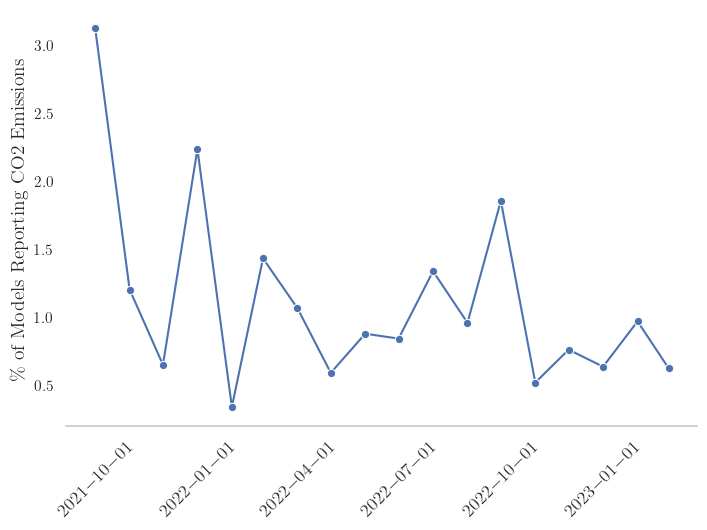

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

xtick_interval = 3

df['year_month'] = pd.to_datetime(df['year_month'])
grouped_data = df.groupby('year_month').agg({'co2_reported': 'sum', 'modelId': 'count'}).reset_index().iloc[34:,:]

# Calculate the ratio of models reporting CO2 emissions over the total number of models
grouped_data['co2_reporting_ratio'] = (grouped_data['co2_reported'] / grouped_data['modelId']) * 100

#only considering up to 31st march
grouped_data = grouped_data.iloc[:-1]

# Plot the evolution of the ratio of models reporting CO2 emissions over the total number of models
plt.figure(figsize=(set_size(516)[0]+1, set_size(516)[1]+1))
ax = sns.lineplot(data=grouped_data, x='year_month', y='co2_reporting_ratio', marker='o')
xticks = grouped_data['year_month'][::xtick_interval]
xticks = xticks.dt.strftime('%Y-%m')  # Convert Timestamp objects to strings
ax.set_ylabel('\% of Models Reporting CO2 Emissions', fontsize=14)
ax.set_xticks(xticks)
ax.set_xlabel(None)
plt.xticks(rotation=45, fontsize=13)


ax.grid(False)

sns.despine(left=True, bottom=False)
plt.show()


#### Applying linear regression

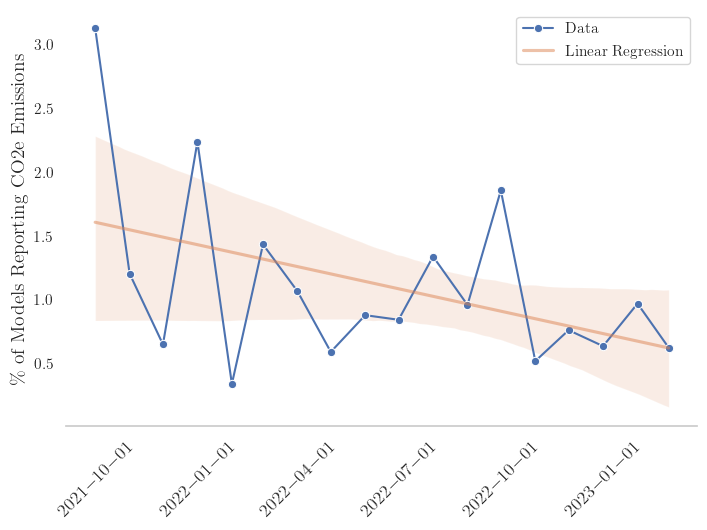

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df['year_month'] = pd.to_datetime(df['year_month'])
grouped_data = df.groupby('year_month').agg({'co2_reported': 'sum', 'modelId': 'count'}).reset_index().iloc[34:,:]

# Calculate the ratio of models reporting CO2 emissions over the total number of models
grouped_data['co2_reporting_ratio'] = (grouped_data['co2_reported'] / grouped_data['modelId']) * 100

# Convert datetime objects to numerical values
ref_date = pd.Timestamp('1970-01-01')
grouped_data['year_month_num'] = (grouped_data['year_month'] - ref_date) / pd.Timedelta(1, 'D')

# only considering up to 31st march
grouped_data = grouped_data.iloc[:-1]

# Plot the evolution of the ratio of models reporting CO2 emissions over the total number of models
plt.figure(figsize=(set_size(516)[0]+1, set_size(516)[1]+1))
ax = sns.lineplot(data=grouped_data, x='year_month', y='co2_reporting_ratio', marker='o', label='Data')
sns.regplot(data=grouped_data, x='year_month_num', y='co2_reporting_ratio', scatter=False, label='Linear Regression', ax=ax, line_kws={'alpha': 0.5})

ax.set_ylabel('\% of Models Reporting CO2e Emissions', fontsize=14)
xticks = grouped_data['year_month'][::xtick_interval]
xticks = xticks.dt.strftime('%Y-%m')  # Convert Timestamp objects to strings
ax.set_xticks(xticks)
ax.set_xlabel(None)
plt.xticks(rotation=45, fontsize=13)
ax.grid(False)
sns.despine(left=True, bottom=False)
plt.legend()
plt.savefig('carbon_emissions_reporting_evolution.pdf', bbox_inches='tight')
plt.show()


In [67]:
# Maximum CO2 reporting percentage
max_reporting_ratio = grouped_data['co2_reporting_ratio'].max()
print(f"Maximum CO2 reporting percentage: {max_reporting_ratio:.2f}%")

# Overall CO2 reporting percentage
overall_reporting_ratio = grouped_data['co2_reported'].sum() / grouped_data['modelId'].sum()
print(f"Overall CO2 reporting percentage: {overall_reporting_ratio * 100:.2f}%")

# Last month CO2 reporting percentage
last_month_reporting_ratio = grouped_data.iloc[-1]['co2_reporting_ratio']
print(f"Last month CO2 reporting percentage: {last_month_reporting_ratio :.2f}%")

# Median CO2 reporting percentage
median_reporting_ratio = grouped_data['co2_reporting_ratio'].median()
print(f"Median CO2 reporting percentage: {median_reporting_ratio:.2f}%")

Maximum CO2 reporting percentage: 3.12%
Overall CO2 reporting percentage: 0.90%
Last month CO2 reporting percentage: 0.62%
Median CO2 reporting percentage: 0.92%


In [68]:
import numpy as np
import statsmodels.api as sm

# Create a new column with the index number (time) as a numeric variable
grouped_data['time'] = np.arange(len(grouped_data))

# Define the dependent variable (y) and independent variable (X)
y = grouped_data['co2_reporting_ratio']
X = grouped_data['time']

# Add a constant to the independent variable (X)
X = sm.add_constant(X)

# Perform the linear regression
model = sm.OLS(y, X)
results = model.fit()

# Get the p-value for the slope coefficient (β1)
p_value_slope = results.pvalues['time']


Remember, these p-values still should be corrected!! Correction on HFGeneralAnalysis.ipynb

In [69]:
p_value_slope

0.06421025271260412

### Is the energy consumption reported increasing?

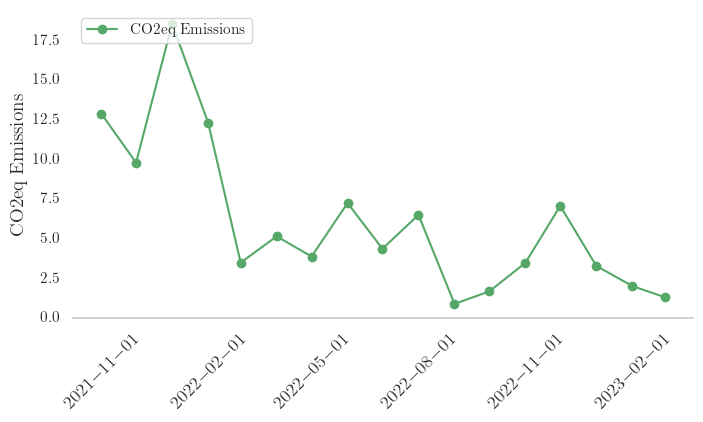

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Group the data by 'year_month' and compute median values for the relevant columns
grouped_df = df.groupby('year_month').agg({
    'co2_eq_emissions': 'median',
}).reset_index()

# Convert 'year_month' to datetime format
grouped_df['year_month'] = pd.to_datetime(grouped_df['year_month'])

# Filter rows to start at the end of 2021
start_date = pd.to_datetime('2021-11')
filtered_df = grouped_df[grouped_df['year_month'] >= start_date]

# up to march 31st
filtered_df = filtered_df.iloc[:-1]

xtick_interval = 3
xticks = filtered_df['year_month'][::xtick_interval]

# Plot the evolution of average CO2eq emissions, model size, and performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(filtered_df['year_month'], filtered_df['co2_eq_emissions'], 'g-o', label='CO2eq Emissions')  # Add 'o' as marker
ax.set_ylabel('CO2eq Emissions', fontsize=14)
ax.set_xticks(xticks)
plt.xticks(rotation=45, fontsize=13)
ax.legend(loc='upper left')

ax.grid(False)
sns.despine(left=True, bottom=False) 
# plt.savefig('energy_consumption_evolution.pdf', bbox_inches='tight')
plt.show()


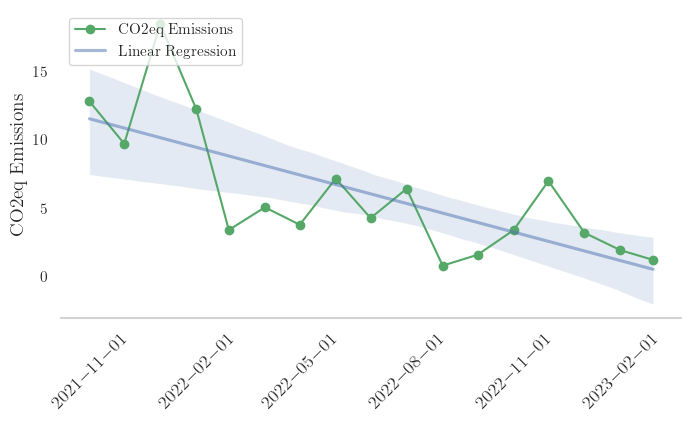

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Group the data by 'year_month' and compute median values for the relevant columns
grouped_df = df.groupby('year_month').agg({
    'co2_eq_emissions': 'median',
}).reset_index()

# Convert 'year_month' to datetime format
grouped_df['year_month'] = pd.to_datetime(grouped_df['year_month'])

# Filter rows to start at the end of 2021
start_date = pd.to_datetime('2021-11')
filtered_df = grouped_df[grouped_df['year_month'] >= start_date]

# Convert datetime objects to numerical values
ref_date = pd.Timestamp('1970-01-01')
filtered_df['year_month_num'] = (filtered_df['year_month'] - ref_date) / pd.Timedelta(1, 'D')

filtered_df = filtered_df.iloc[:-1]

xtick_interval = 3
xticks = filtered_df['year_month'][::xtick_interval]

# Plot the evolution of average CO2eq emissions, model size, and performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(filtered_df['year_month'], filtered_df['co2_eq_emissions'], 'g-o', label='CO2eq Emissions')  # Add 'o' as marker
sns.regplot(data=filtered_df, x='year_month_num', y='co2_eq_emissions', scatter=False, label='Linear Regression', ax=ax, line_kws={'alpha': 0.5})

ax.set_xlabel(None)
ax.set_ylabel('CO2eq Emissions', fontsize=14)
ax.set_xticks(xticks)
plt.xticks(rotation=45, fontsize=13)
ax.legend(loc='upper left')

ax.grid(False)
sns.despine(left=True, bottom=False) 
# plt.savefig('carbon_emissions_evolution.pdf', bbox_inches='tight')
plt.show()


In [72]:
# Maximum CO2 reporting percentage
max_reported = filtered_df['co2_eq_emissions'].max()
print(f"Maximum CO2 reported: {max_reported:.2f}")

# Overall CO2 reporting percentage
overall_reported = filtered_df['co2_eq_emissions'].sum() / filtered_df.shape[0]
print(f"Overall CO2 reported: {overall_reported:.2f}")

# Last month CO2 reporting percentage
last_month_reported = filtered_df.iloc[-1]['co2_eq_emissions']
print(f"Last month CO2 reported: {last_month_reported:.2f}")

# Median CO2 reporting percentage
median_reported = filtered_df['co2_eq_emissions'].median()
print(f"Median CO2 reported: {median_reported:.2f}")

Maximum CO2 reported: 18.48
Overall CO2 reported: 6.04
Last month CO2 reported: 1.24
Median CO2 reported: 4.30


In [73]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime

filtered_df['time'] = np.arange(len(filtered_df))


# Perform linear regression
X = sm.add_constant(filtered_df['time'])
y = filtered_df['co2_eq_emissions']
model = sm.OLS(y, X).fit()

# Obtain the p-value for the slope (the second element in model.pvalues)
slope_pvalue = model.pvalues[1]

Remember, these p-values still should be corrected!! Correction on HFGeneralAnalysis.ipynb

In [74]:
print(f"Slope p-value: {slope_pvalue}")

Slope p-value: 0.0010268592930073807


# Domain analysis on carbon emissions reporting models

In [75]:
df_energy_reported = df[df['co2_reported'] == True]

/tmp/ipykernel_33429/3578325700.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_energy_reported['period'] = df_energy_reported['created_at'].dt.to_period('Q')


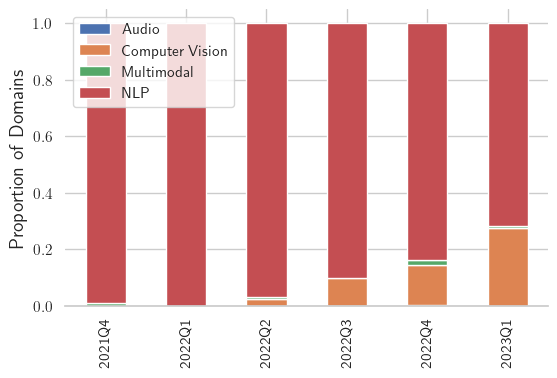

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a 'period' column to group by every 3 months
df_energy_reported['created_at'] = pd.to_datetime(df_energy_reported['created_at'])
df_energy_reported['period'] = df_energy_reported['created_at'].dt.to_period('Q')

# Calculate domain counts for each period
domain_counts = df_energy_reported.groupby('period')['domain'].apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)

# Normalize the counts to get proportions
domain_proportions = domain_counts.div(domain_counts.sum(axis=1), axis=0).iloc[2:-1]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=set_size(450))
domain_proportions.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('Proportion of Domains', fontsize=14)
ax.set_xlabel(None)


plt.legend(loc='upper left')
sns.set(style='whitegrid')

if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

sns.despine(left=True, bottom=False) 
plt.savefig('domain_evolution_energy.pdf', bbox_inches='tight')
plt.show()



/tmp/ipykernel_33429/988622938.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['period'] = df['created_at'].dt.to_period('Q')


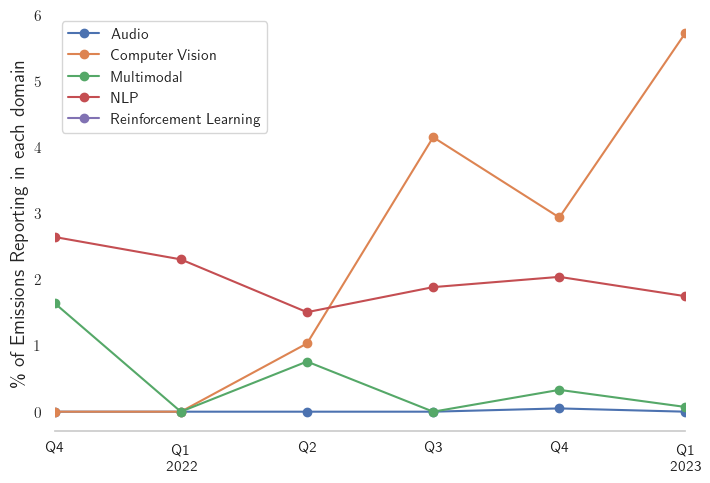

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 'period' column to group by every 3 months
df['created_at'] = pd.to_datetime(df['created_at'])
df['period'] = df['created_at'].dt.to_period('Q')

# Calculate domain counts for each period
total_domain_counts = df.groupby('period')['domain'].apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)
energy_domain_counts = df[df['co2_reported']==True].groupby('period')['domain'].apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)

# Calculate the proportion of models in each domain reporting carbon emissions
domain_proportions = energy_domain_counts.div(total_domain_counts).iloc[13:-1]*100

# Plot the line plot
fig, ax = plt.subplots(figsize=(set_size(516)[0]+1, set_size(516)[1]+1))
domain_proportions.plot(ax=ax, marker='o')
ax.set_ylabel('\% of Emissions Reporting in each domain', fontsize=14)
ax.set_xlabel(None)

ax.grid(False)


plt.legend(loc='upper left')
sns.set(style='whitegrid')

if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })


sns.despine(left=True, bottom=False) 
plt.savefig('evolution_energy_percentage_inside_domain.pdf', bbox_inches='tight')
plt.show()


In [78]:
df[df['co2_reported']==True]['domain'].value_counts()

NLP                1160
Computer Vision     188
Multimodal           11
Audio                 1
Name: domain, dtype: int64

In [60]:
df = read_df_processed()

/tmp/ipykernel_33429/1477532181.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


## Energy reporting classification

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to determine if a model is optimized
def is_optimized(tags):
    optimization_tags = ['optimized', 'pruned', 'distilled']
    return any(tag in tags for tag in optimization_tags)

# Classify the models based on energy reporting and optimization
def classify_model(row):
    tags = [col for col in row.index if col.startswith('is_')]
    if not row['co2_reported']:
        if pd.notnull(row['hardware_used']):
            return 'Context Reporting'
        else:
            return 'Unknown Energy Efficiency'
    elif row['co2_reported'] and not (pd.notna(row['hardware_used'])):
        return 'Basic Energy Reporting'
    elif row['co2_reported'] and pd.notna(row['hardware_used']):
        return 'Energy Awareness'
    elif row['co2_reported'] and is_optimized(tags):
        return 'Energy Optimization'
    elif row['co2_reported'] and is_optimized(tags) and 'EcoCard' in tags:
        return 'Certified Energy Efficiency'
    else:
        return 'Unknown Energy Efficiency'

df['energy_classification'] = df.apply(classify_model, axis=1)


Modify the code below to check top 5 models in each category

In [34]:
category = 'Energy Awareness'
df[df['energy_classification'] == category].sort_values(by='likes', ascending=False).head(5)

,modelId,datasets,datasets_size,co2_eq_emissions,source,training_type,geographical_location,hardware_used,accuracy,loss,...,is_gptj,is_llama,is_lora,is_ml-agents-soccertwos,is_ppo,is_pyramids,is_setfit,is_snowballtarget,is_swin,energy_classification
44012,bloom,[],NaN,24700000.0,"Estimating the Carbon Footprint of BLOOM, a 17...",pre-training,"Orsay, France",384 A100 80GB GPUs,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Energy Awareness
12995,dalle-mini,[],NaN,7540.0,MLCo2 Machine Learning Impact calculator,NaN,East USA,TPU v3-8,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Energy Awareness
32,distilgpt2,[openwebtext],3.976949e+10,149200.0,NaN,NaN,"** unavailable, assumed East US for calculations",** 8 16GB V100,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Energy Awareness
53351,dalle-mega,[],NaN,450300.0,MLCo2 Machine Learning Impact calculator,NaN,East USA,TTPU v3-256,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Energy Awareness
154076,swissbert,[],NaN,0.6,NaN,NaN,NaN,RTX 2080 Ti.,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Energy Awareness


In [35]:
df[['auto', 'energy_classification']].value_counts()

auto   energy_classification    
False  Unknown Energy Efficiency    168800
True   Basic Energy Reporting         1291
False  Context Reporting               194
       Energy Awareness                 79
True   Unknown Energy Efficiency        51
False  Basic Energy Reporting           47
dtype: int64

In [36]:
df['energy_classification'].value_counts()

Unknown Energy Efficiency    168851
Basic Energy Reporting         1338
Context Reporting               194
Energy Awareness                 79
Name: energy_classification, dtype: int64